# Deep Learning II: CNN (Convolutional neural network)

## Stand Alone Reading: Introduction to CNN

- **Introduction to CNNs**:
  - Proposed by Yann Lecun in 1989.
  - Specialized kind of neural networks for processing data with a known, grid-like topology.
  - Examples include time-series data (1D grid) and image data (2D grid of pixels).
  - Effective in image recognition and classification tasks.

- **Biological Inspiration**:
  - Motivated by experiments by Hubel and Wiesel on a cat’s visual cortex.
  - Visual cortex has regions of cells sensitive to specific regions in the visual field.
  - Neurons in the visual cortex are connected using a layered architecture.
  - Early layers encode primitive shapes, while later layers encode more complex shapes.

- **Neocognitron and LeNet-5**:
  - Neocognitron, proposed by Kunihiko Fukushima in 1979, was an early neural model inspired by biological principles.
  - However, it lacked weight sharing, a key feature of modern CNNs.
  - LeNet-5, developed by Yann Lecun in 1989, was one of the first fully convolutional architectures, incorporating weight sharing.
 - **Architectural Ideas**: 
  - CNNs combine three architectural ideas: 
    - Local receptive fields
    - Shared weights
    - Spatial or temporal sub-sampling
  - These ideas ensure some degree of shift, scale, and distortion invariance.

- **Image Classification Challenges**:
  - Classifying images with ordinary fully connected feed-forward networks poses problems due to:
    - High dimensional input data (hundreds or millions of pixels)
    - Large number of parameters in fully connected layers (e.g., tens of thousands of weights)
    - Increased capacity requiring larger training sets
    - Memory requirements for storing many weights may limit hardware implementations

- **Deficiency of Fully-Connected Architectures**:
  - Fully-connected architectures ignore the topology of the input, allowing input variables to be presented in any fixed order without affecting the outcome of training.
  - Images have a strong 2D local structure, with nearby pixels being highly correlated.

- **Importance of Local Correlations**:
  - Local correlations in images are the reason for advantages of:
    - Extracting and combining local features before recognizing spatial or temporal objects
    - Classifying configurations of neighboring pixels into categories such as edges, corners, etc.

### Simple explanation

The already mentioned multilayer perceptrons represent the most general and powerful feedforward neural network model possible; they are organised in layers, such that every neuron within a layer receives its own copy of all the outputs of the previous layer as its input. This kind of model is perfect for the right kind of problem – learning from a fixed number of (more or less) unstructured parameters.

> However, consider what happens to the number of parameters (weights) of such a model when being fed raw image data (f.e. a $200 \times 200$ pixel image connected to 1024 neurons) =  40960000.

The situation quickly becomes unmanageable as image sizes grow larger, way before reaching the kind of images people usually want to work with in real applications.

A common solution is to downsample the images to a size where MLPs can safely be applied. However, if we directly downsample the image, we potentially lose a wealth of information; it would be great if we would somehow be able to still do some useful (without causing an explosion in parameter count) processing of the image, prior to performing the downsampling.

It turns out that there is a very efficient way of pulling this off, and it makes advantage of the structure of the information encoded within an image – it is assumed that pixels that are spatially closer together will "cooperate" on forming a particular feature of interest much more than ones on opposite corners of the image. Also, if a particular (smaller) feature is found to be of great importance when defining an image's label, it will be equally important if this feature was found anywhere within the image, regardless of location.

Enter the convolution operator. Given a two-dimensional image, $I$, and a small matrix, $K$ of size $h \times w$, (known as a convolution kernel), which we assume encodes a way of extracting an interesting image feature, we compute the convolved image, $I∗K$, by overlaying the kernel on top of the image in all possible ways, and recording the sum of elementwise products between the image and the kernel:

$$
output(x,y) = (I \otimes K)(x,y) = \sum_{m=0}^{M-1} \sum_{n=1}^{N-1} K(m,n) I(x-n, y-m)
$$

The convolution operator forms the fundamental basis of the convolutional layer of a CNN. The layer is completely specified by a certain number of kernels, $K$, and it operates by computing the convolution of the output images of a previous layer with each of those kernels, afterwards adding the biases (one per each output image). Finally, an activation function, $\sigma$, may be applied to all of the pixels of the output images. 

Typically, the input to a convolutional layer will have $d$ channels (e.g., red/green/blue in the input layer), in which case the kernels are extended to have this number of channels as well.

Note that, since all we're doing here is addition and scaling of the input pixels, the kernels may be learned from a given training dataset via gradient descent, exactly as the weights of an MLP. In fact, an MLP is perfectly capable of replicating a convolutional layer, but it would require a lot more training time (and data) to learn to approximate that mode of operation.

https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2



## Our first Convolution Neural Network

(all concepts are explained in this class - just see it working for now)

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

"""
## Prepare the data
"""

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

"""
## Build the model
"""

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding = 'same'),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding = 'same'),

        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding = 'same'),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding = 'same'),

        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding = 'same'),

        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),

        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

"""
## Train the model
"""

batch_size = 128
epochs = 2

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

"""
## Evaluate the trained model
"""

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,690 (420.66 KB)

 Trainable params: 107,690 (420.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.7725 - loss: 0.6817 - val_accuracy: 0.9857 - val_loss: 0.0542
Epoch 2/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9712 - loss: 0.0939 - val_accuracy: 0.9910 - val_loss: 0.0364
Test loss: 0.03518311679363251
Test accuracy: 0.9886999726295471


## Convolution Operator

### Stand Alone Reading

In mathematics, convolution is a mathematical operation on two or more than two
functions that produces a new function expressing how the shape of one is modified by the
others. Usually, the convolution operation used in CNNs does not correspond precisely to
the definition of convolution as used in other fields such as engineering (signal processing)
or pure mathematics.

Suppose that you are James T. Kirk from Star Trek, and you are captured in a planet, you
want to track the location of USS Enterprise with a laser sensor. The laser sensor provides
a single output $x(t)$, the position of the Enterprise at time $t$. Bot $x$ and $t$ are real-valued,
i.e., you can get a different reading from the laser sensor at any instant time. Now suppose
that your laser sensor is somewhat noisy. 

To obtain a less noisy estimate of the Enterprise’s position, we would like to average together several measurements. Of course, more recent measurements are more relevant, so we will want this with a weighted average that gives more weight to recent measurements. If we apply such a weighted average operation at every moment, we obtain a new function \(s\) providing a smoothed estimate of the position of the spaceship:

<font size="4">

$$ s(t) = \int x(t_0) w(t-t_0) \, dt_0 $$

</font>

This operation is called convolution, denoted as:

<font size="4">

$$ s(t) = (x \ast w)(t) $$

</font>

Of course, \(w\) needs to be a valid probability density function, and \(w\) needs to be 0 for all negative arguments, or it will look into the future, which is not okay. However, usually when we work with data on a computer, time will be discretized, and our sensor will provide data at regular intervals. In our example, it might be more realistic to assume that our laser provides a measurement once per second.

The time index \(t\) can take on only integer values. If we now assume that \(x\) and \(w\) are defined only on integer \(t\), we can define the discrete convolution as:

<font size="4">

$$ s(t) = (x \ast w)(t) = \sum_{n= -\infty}^{\infty} x(n)w(t-n) $$

</font>

\(w\) is sometimes referred to as the kernel, and the output of the convolution operator is sometimes referred to as the feature map. Often, the convolution operator can be applied over more than one axis at a time. For example, if we use a two-dimensional image \(I\) as our input, we would probably also use a two-dimensional kernel \(K\):

<font size="4">

$$ F(i,j) = (I \ast K)(i,j) = \sum_{m}\sum_{n} I(m,n)K(i-m,j-n) $$

</font>

Instead convolution, many neural network libraries implement a related function called the
cross-correlation.
<font size="4">
$$F(i,j) = (I \ast K)(i,j)=\sum_{m}\sum_{n} I(i+m,j+n)K(m,n)$$
</font>

We can think cross-correlation as a Hadamard Product but after the production of input ant the kernel, output of the cross-entropy is the sum of all elements of output of the Hadamard Product

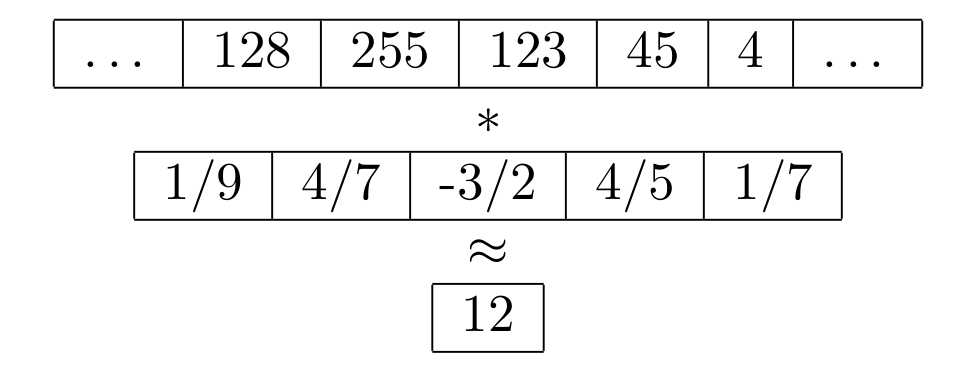

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/cross.png",width=500, height=500)

The convolution on engineering, signal processing is a very large subject to study. It will
be shown more later.

## The Architecture

The image illustrates a typical Convolutional Neural Network (CNN) architecture used for image classification. Starting with a 28x28 grayscale image input, the network applies a series of convolutional and pooling operations to extract features and reduce the spatial dimensions while increasing the depth of the feature maps. The final set of feature maps is flattened into a 1D vector, which is then passed through fully connected layers to perform classification across 10 possible classes. Key components include the use of ReLU activations, max-pooling layers, and a softmax output layer for prediction.

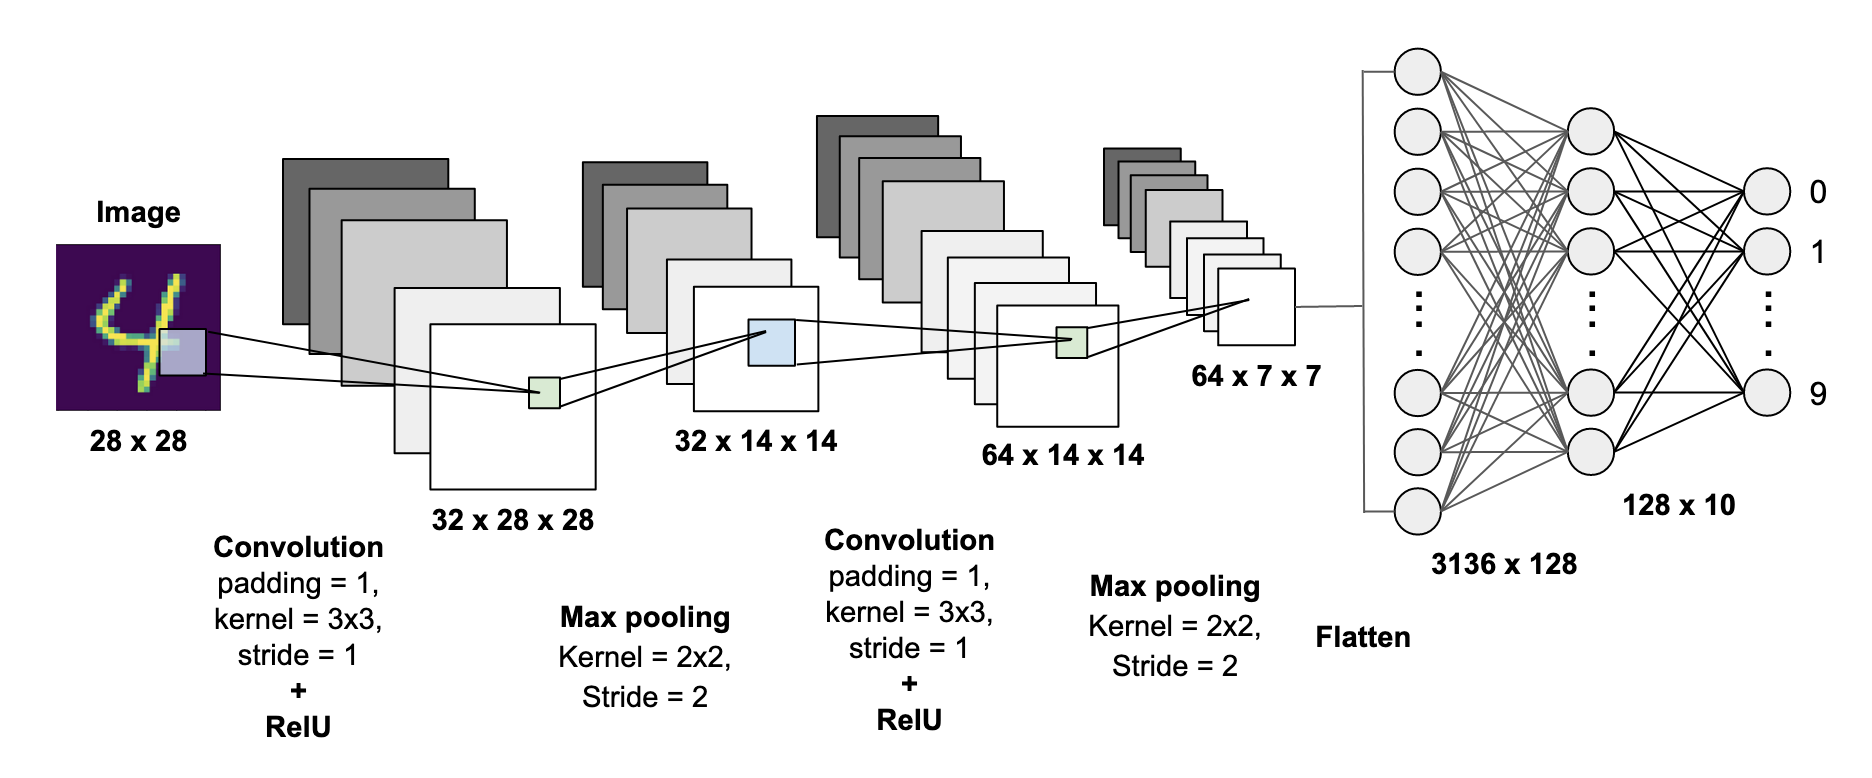

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/mnistarch.png",width=1000, height=1000)

### Fully Connected Layers and Classification

- **Fully Connected Layers**:
  - Each feature in the final spatial layer is connected to each hidden state in the first fully connected layer.
  - Functions similarly to a traditional feed-forward network.
  - More than one fully connected layer may be used to increase computational power towards the end.
  - Connections among these layers are structured like traditional feed-forward networks.
  - Vast majority of parameters lie in the fully connected layers.
  - Example: If each of two fully connected layers has 4096 hidden units, the connections between them have more than 16 million weights.

- **Output Layer**:
  - Application-specific design, such as classification.
  - Fully connected to every neuron in the penultimate layer.
  - Activation function (e.g., logistic, softmax, linear) chosen based on the application nature.

- **Flattening the Final Feature Map**:
  - Transforming image $W \times H \times D$ matrix into $1 \times (W \times H \times D)$ array.
  - First fully connected layer has $W \times H \times D$ neurons.
  - Example: For handwritten digit classification with final convolution layer generating 10 feature maps of size $7\times7$, first fully connected layer has 490 neurons, and output layer has 10 neurons for classifying digits 0 to 9.

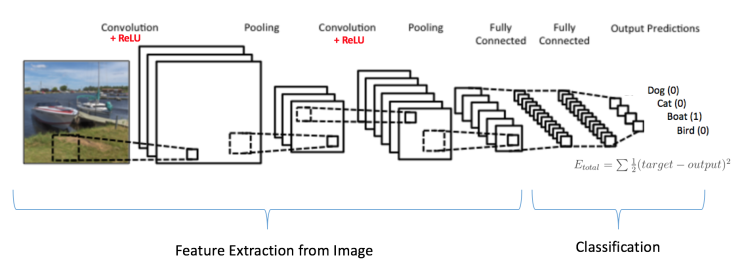

In [4]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/fullyc.png",width=900, height=900)

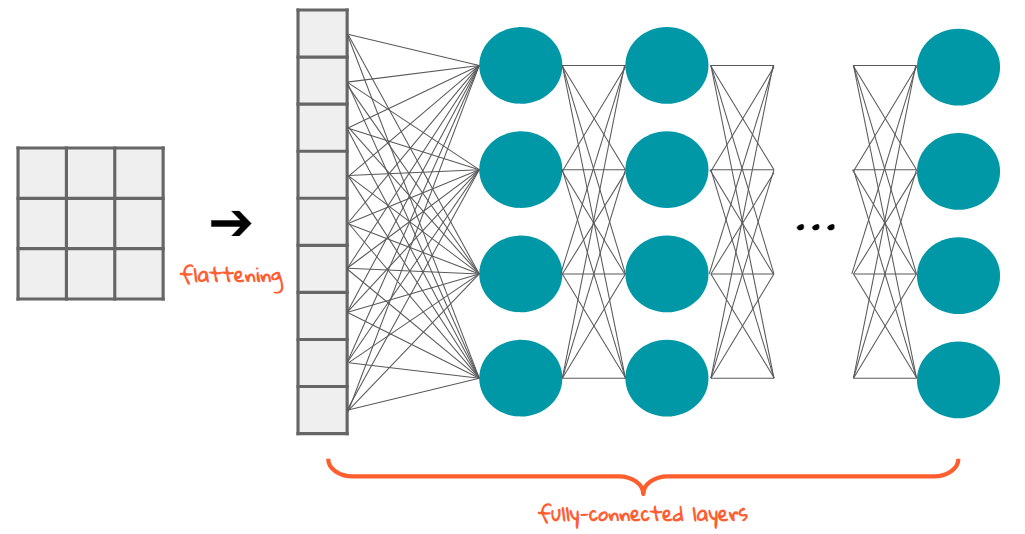

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/flattening.png",width=500, height=500)

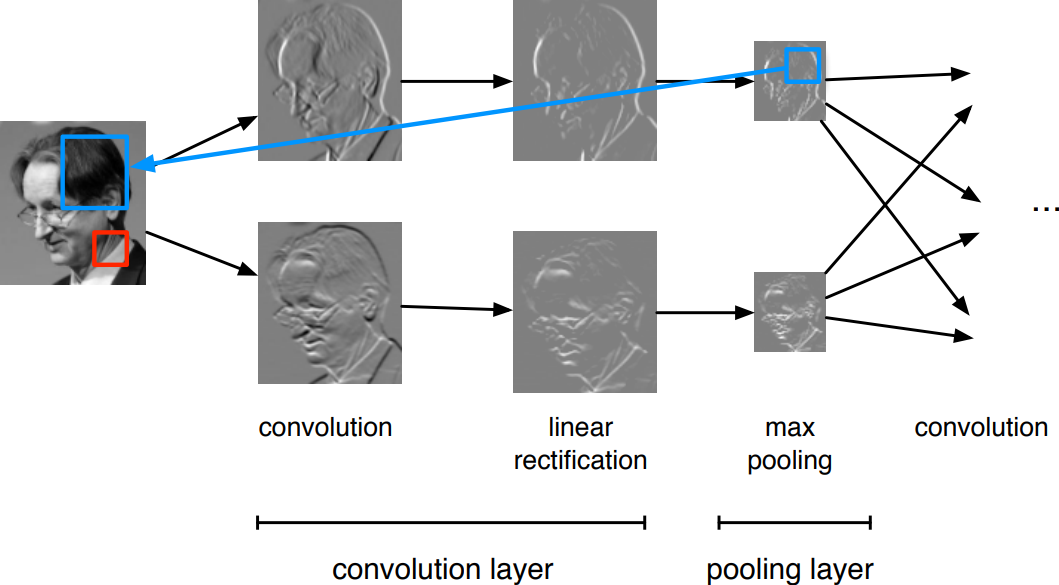

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/convnet-geoff.png",width=700, height=500)

## CNN Concepts

### Convolution On Image

The image demonstrates a basic example of a convolution operation applied to a 5x5x1 feature image using a 2x2x1 filter. With a stride of 1 and no padding, the convolution process slides the filter across the feature image, computing the dot product at each position. This operation reduces the spatial dimensions of the feature image from 5x5 to 4x4, as shown on the right. The resulting feature image highlights the extracted features from the input image based on the applied filter.



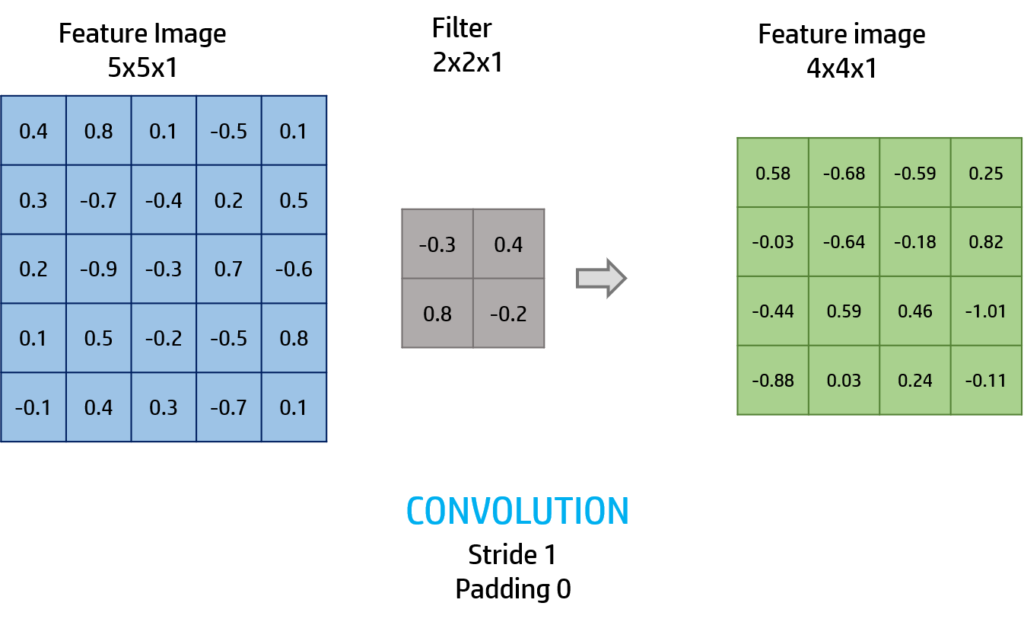

In [7]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/convimg.png",width=700, height=500)

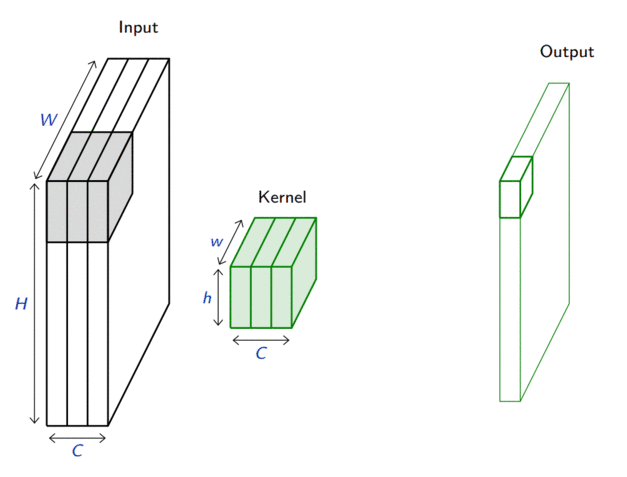

In [8]:
from IPython.display import Image;
Image("./images/3d-conv.gif")

### Pooling

- **Convolutional Layer**:
  - First stage in a CNN architecture.
  - Performs convolution operation, applying filters to input data to extract features.
  
- **Non-linear Activation**:
  - Second stage in a CNN architecture.
  - Applies a non-linear activation function, such as ReLU, to introduce non-linearity into the network and enable better feature representation.
  
- **Pooling (Sub-sampling)**:
  - Third stage in a CNN architecture.
  - Modifies the output of the layer further by summarizing statistics of nearby outputs.
  - Popular pooling functions include:
    - **Max Pooling**: Finds the maximum element within a rectangular or square neighborhood.
    - **Average Pooling**: Computes the average value of elements in a neighborhood.
    - **$L^2$ Norm Pooling**: Computes the $L^2$ norm of elements in a neighborhood.
    - **Weighted Average Pooling**: Computes the weighted average based on the distance from the central pixel.
  - Pooling helps make the representation approximately invariant to small translations of the input.
  - Invariance to translation means that small translations of the input result in minimal changes to the pooled outputs.

You can see a example:

In [9]:
## Skip in class - just for studetns to read
import numpy as np
def pool2d(im,kernel,mode='max'):
    kernel0,kernel1 = kernel
    feature_map = 255 * np.ones(shape=(int(im.shape[0]/kernel0)+1,
                                       int(im.shape[1]/kernel1)+1))
    for i in range(0,im.shape[0],kernel0):
        for j in range(0,im.shape[1],kernel1):
            if(mode == "max"):
                feature_map[int(i/kernel0),int(j/kernel1)] = np.max(im[i:i+kernel0,j:j+kernel1])
            if(mode == "avg"):
                feature_map[int(i/kernel0),int(j/kernel1)] = im[i:i+kernel0,j:j+kernel1].mean()
    return feature_map

(567, 567) (48, 48) (48, 48)


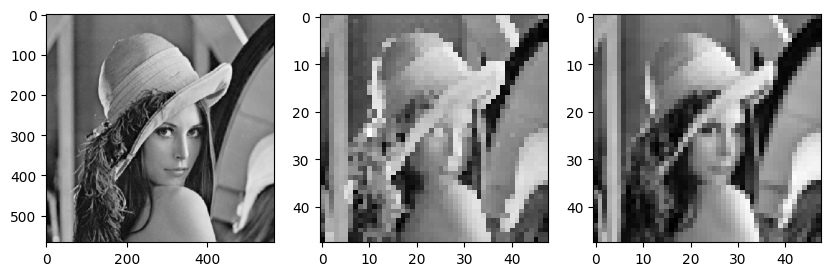

In [10]:
import cv2
import matplotlib.pyplot as plt
img1 = cv2.imread('./images/lena.png',0)
maxpool = pool2d(img1,(12,12),'max')
avgpool = pool2d(img1,(12,12),'avg')
print(img1.shape, maxpool.shape, avgpool.shape)

fig, axs = plt.subplots(1,3,figsize=(10,10))
axs[0].imshow(img1,cmap='gray')
axs[1].imshow(maxpool,cmap='gray')
axs[2].imshow(avgpool,cmap='gray')

Invarianvce to local translation can be very useful property if we care more about whether some feature is presented exactly where it is. For example, when determining whether an image contains a face, we need not know the location of the eyes with pixel-perfect accuracy. We just need to know that there is an eye on the left and right side of the face. In other contexts, it is more important to preserve the location of a feature.

### Padding

One observation is that the convolution operation reduces the size of the $(q+1)$ th layer in comparsion with the size of the $q$ th layer. This type of reduction in size is not desirable in general, because it tends to lose some information along the borders of the image (or feature map in the hidden layers). This problem can be resolved by using the padding. Kernel size in the layer $q$ denoted as $K_q$ ; in padding, one adds $(K_q-1)/2$ "pixels" all around the borders of the image-feature map in order to maintain the spatial footprint. Note that these pixels are really feature values in the case of the padding hidden layers. The value of each of each of these padded feature values is set to 0, irrespective of whether the input or the feature maps at the hidden layers are being padded. As a result, the spatial height and width of the input volume will both increase by $(K_q-1)$, which is exactly what they reduce by (in the output volume) after the convolution is performed. The padded portions do not contribute to the final dot product due to their values are set to 0.

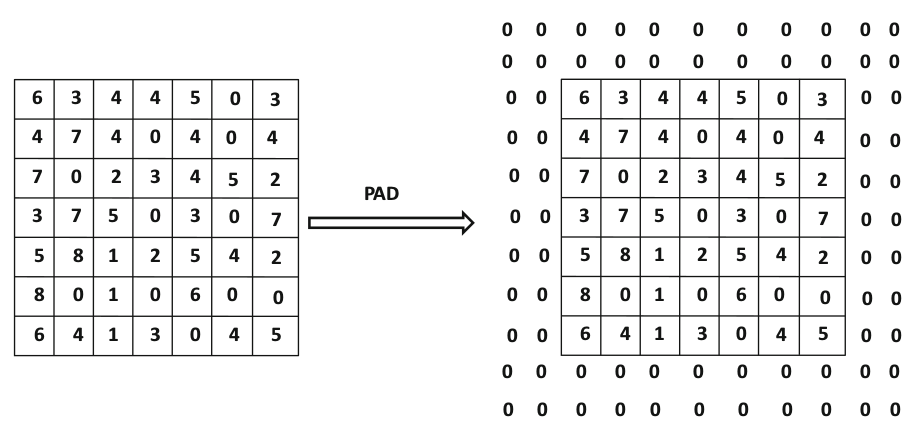

In [11]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/padding.png",width=700, height=500)

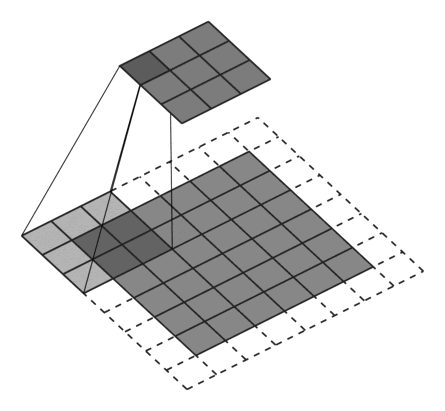

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/convwpad.png",width=400, height=400)

Look for *half padding*, *valid padding*, and *full padding*.

### Stride

There are other ways in which convolution can reduce the spatial footprint of the image. It is not necessary to perform the convolution at every spatial position in the layer. One can reduce the level of granularity of the convolution by using the notion of strides. When a stride of $S_q$ is used in the $q$th layer, the convolution is performed at the locations 1, $S_q+1$, $2S_q+1$, and so on along both spatial dimensions of the layer. The spatial size of the output on performing this convolution has height of $(H_q - K_q)/S_q + 1$ and a width of $(W_q - K_q)/S_q + 1$. \\
It is most common to use a stride of 1, although a stride of 2 is occasionally used as well. It is rare to use strides more than 2 in normal circumstances. Even though a stride of 4 was used in the input layer of the winning architecture of the ILSVRC (ImageNet Large Scale Visual Recognition Challenge) competition of 2012, the winning entry in the subsequent year reduced the stride to 2 to improve accuracy. Larger strides can be helpful in memory-constrained settings or to reduce overfitting if the spatial resolution is unnecessarily high. Strides have the effect of rapidly increasing the receptive field of each feature in the hidden layer, while reducing the spatial footprint of the entire layer.

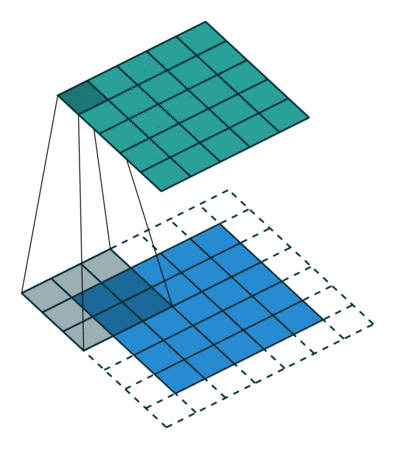

In [13]:
from IPython.display import Image;
Image("./images/same_padding_no_strides.gif")

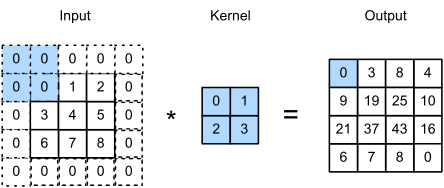

In [14]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/stride.png",width=400, height=400)

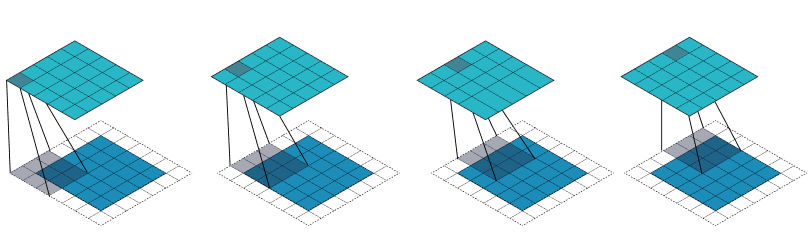

In [15]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/stride2.png",width=900, height=900)

### The ReLU Layer

- **Nonlinear Activation Functions**:
  - Preferred in neural networks as they allow nodes to learn more complex structures in the data.
  - Two widely used nonlinear activation functions are:
    - **Sigmoid Activation Function**:
      - Transforms input into values between 0.0 and 1.0.
      - Popular until the early 1990s.
      - Suffers from saturation, where large values snap to 1.0 and small values snap to 0.0.
    - **Hyperbolic Tangent (tanh) Activation Function**:
      - Similar to sigmoid, but outputs values between -1.0 and 1.0.
      - Preferred over sigmoid in the late 1990s and 2000s due to easier training and better performance.
      - Also suffers from saturation and limited sensitivity.
  
- **ReLU Activation Function**:
  - Applied interleaved with the convolution and pooling operations in CNNs.
  - Element-wise operation applied per pixel in a layer.
  - Replaces all negative pixel values in the feature map by zero.
  - Introduces non-linearity to increase the model's ability to capture non-linear features in images.
  - Helps overcome the linearity of convolution operations and accounts for non-linearities in real-world data.

### Dropout



Dropout provides us that a computationally inexpensive but powerful method of regularizing a broad family of models. To a first approximation, dropout can be thought of as a method of making bagging practical for ensembles of very many large neural networks. Bagging involves training multiple models, and evaulating multiple models on each test example. This seems impractical when each model is a large neural network, since training and evaulating such networks costly in terms of runtime and memory. It is common to use ensembles of five to ten neural networks but more than this rapidly becomes unwidely. Dropout provides an inexpensive approximation to training and evaulating a bagged ensemble of exponentially many neural netwoks.\\
Specifically, dropout trains the ensemble consisting of all sub-networks that
can be formed by removing non-output units from an underlying base network. In most modern neural networks, based on a series ofaffine transformations and nonlinearities, we can effectively remove a unit from a network by multiplying its output value by zero. 

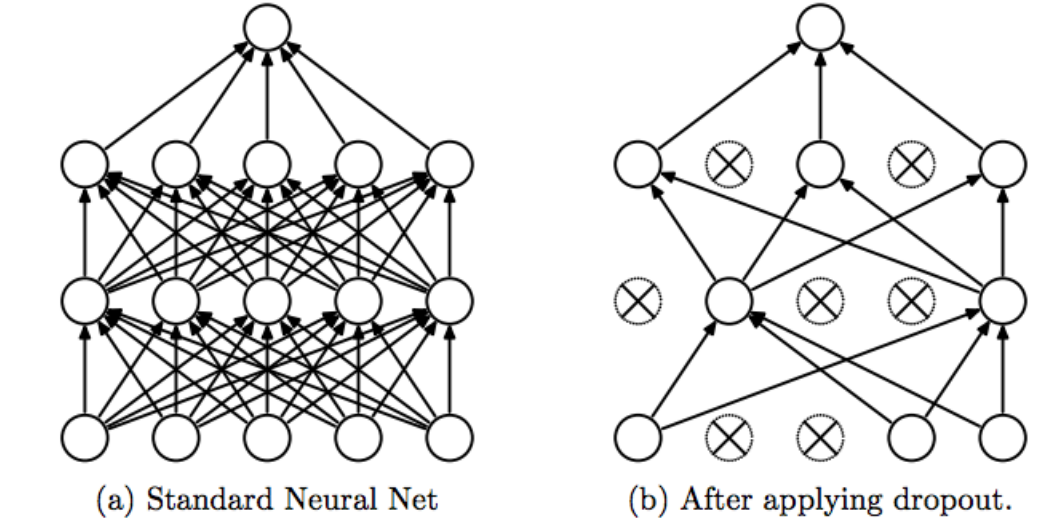

In [16]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "./images/dropout.png",width=700, height=500)

## Lets review the original code

In [17]:
## Identify where in each part of the code, the concepts were applied

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

"""
## Prepare the data
"""

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

"""
## Build the model
"""

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding = 'same'),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding = 'same'),

        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding = 'same'),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding = 'same'),

        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding = 'same'),

        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),

        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

"""
## Train the model
"""

batch_size = 128
epochs = 2

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

"""
## Evaluate the trained model
"""

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,690 (420.66 KB)

 Trainable params: 107,690 (420.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.7714 - loss: 0.6766 - val_accuracy: 0.9857 - val_loss: 0.0486
Epoch 2/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9717 - loss: 0.0887 - val_accuracy: 0.9903 - val_loss: 0.0354
Test loss: 0.03037959523499012
Test accuracy: 0.9901999831199646
